In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
def load_images_and_labels(images_directory, image_size=(128, 128)):
    features = []
    labels = []

    for file in os.listdir(images_directory):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            label = file.split('_')[0]  # Extracts the substance name as the label
            image_path = os.path.join(images_directory, file)
            image = cv2.imread(image_path)
            image = cv2.resize(image, image_size)
            features.append(image)
            labels.append(label)

    return np.array(features), np.array(labels)

images_directory = "C:\\Users\\santo\\Desktop\\python\\tra"

# Load images and labels with a higher resolution
X, y = load_images_and_labels(images_directory, image_size=(128, 128))

# Convert labels to one-hot encoding
label_map = {label: idx for idx, label in enumerate(np.unique(y))}
y_encoded = np.array([label_map[label] for label in y])
num_classes = len(label_map)
print(num_classes)
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Image Preprocessing and Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Using VGG16 as feature extractor
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Initially, don't train existing weights

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model with a low learning rate
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=5, min_lr=0.00001)
model_checkpoint = ModelCheckpoint('best_model123.h5', monitor='val_accuracy', save_best_only=True)

# Train model with data augmentation
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
validation_generator = test_datagen.flow(X_test, y_test, batch_size=32)

model.fit(train_generator, 
          epochs=10,  # Adjust epochs according to your dataset and early stopping
          validation_data=validation_generator, 
          callbacks=[early_stopping, reduce_lr, model_checkpoint])

# Load the best model saved by the ModelCheckpoint
model.load_weights('best_model123.h5')

# Evaluate the model with the test data
test_loss, test_acc = model.evaluate(test_datagen.flow(X_test, y_test))
print('Test accuracy:', test_acc)


23
Epoch 1/10
3/3 [==============================] - 7s 2s/step - loss: 3.8003 - accuracy: 0.0685 - val_loss: 3.3548 - val_accuracy: 0.0526 - lr: 1.0000e-04
Epoch 2/10
3/3 [==============================] - 6s 2s/step - loss: 3.3929 - accuracy: 0.0411 - val_loss: 3.1869 - val_accuracy: 0.0526 - lr: 1.0000e-04
Epoch 3/10
3/3 [==============================] - 6s 2s/step - loss: 3.2129 - accuracy: 0.0959 - val_loss: 3.0979 - val_accuracy: 0.0526 - lr: 1.0000e-04
Epoch 4/10
3/3 [==============================] - 6s 2s/step - loss: 3.2124 - accuracy: 0.0685 - val_loss: 3.0289 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 5/10
3/3 [==============================] - 7s 2s/step - loss: 3.0737 - accuracy: 0.0959 - val_loss: 2.9789 - val_accuracy: 0.0526 - lr: 1.0000e-04
Epoch 6/10
3/3 [==============================] - 7s 2s/step - loss: 2.8310 - accuracy: 0.1781 - val_loss: 2.9254 - val_accuracy: 0.2105 - lr: 1.0000e-04
Epoch 7/10
3/3 [==============================] - 7s 2s/step - loss: 

In [3]:
from tensorflow.keras.regularizers import l2

# Modify the VGG16 base model to be trainable
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = True  # Make the base model trainable

# Freeze all layers except the last block
for layer in base_model.layers[:-4]:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Changed from Flatten to GlobalAveragePooling2D
    layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),  # Added L2 regularization
    layers.Dropout(0.5),  # Adjust the dropout rate as needed
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Adjust the batch size
train_generator = train_datagen.flow(X_train, y_train, batch_size=16)  # Smaller batch size
validation_generator = test_datagen.flow(X_test, y_test, batch_size=16)

# Callbacks remain the same
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=5, min_lr=0.00001)
model_checkpoint = ModelCheckpoint('best_model123.h5', monitor='val_accuracy', save_best_only=True)

# Train the model
model.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[early_stopping, reduce_lr, model_checkpoint])

# Load the best model and evaluate
model.load_weights('best_model123.h5')
test_loss, test_acc = model.evaluate(test_datagen.flow(X_test, y_test))
print(f'Test accuracy: {test_acc}')


Epoch 1/10
5/5 [==============================] - 10s 2s/step - loss: 3.6813 - accuracy: 0.0274 - val_loss: 3.4657 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/10
5/5 [==============================] - 8s 2s/step - loss: 3.4290 - accuracy: 0.0959 - val_loss: 3.2600 - val_accuracy: 0.0526 - lr: 1.0000e-04
Epoch 3/10
5/5 [==============================] - 8s 2s/step - loss: 3.2800 - accuracy: 0.1507 - val_loss: 3.0240 - val_accuracy: 0.2105 - lr: 1.0000e-04
Epoch 4/10
5/5 [==============================] - 9s 2s/step - loss: 3.1577 - accuracy: 0.1370 - val_loss: 2.8101 - val_accuracy: 0.2632 - lr: 1.0000e-04
Epoch 5/10
5/5 [==============================] - 9s 2s/step - loss: 2.7342 - accuracy: 0.2466 - val_loss: 2.4999 - val_accuracy: 0.4211 - lr: 1.0000e-04
Epoch 6/10
5/5 [==============================] - 8s 2s/step - loss: 2.6253 - accuracy: 0.3151 - val_loss: 2.1751 - val_accuracy: 0.6316 - lr: 1.0000e-04
Epoch 7/10
5/5 [==============================] - 9s 2s/step - loss: 2.

In [4]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model

def load_and_preprocess_image(image_path, image_size=(128, 128)):
    """Load and preprocess an image."""
    image = cv2.imread(image_path)
    image = cv2.resize(image, image_size)
    image = image.astype('float32') / 255.0  # Normalize the image
    return np.expand_dims(image, axis=0)  # Expand dimensions to fit model input

def predict_image_class_with_confidence(model, image_path, inverse_label_map, confidence_threshold=0.3):
    """Predict the class for a single image with confidence check."""
    image = load_and_preprocess_image(image_path)
    predictions = model.predict(image)
    predicted_confidence = np.max(predictions)
    predicted_class_id = np.argmax(predictions, axis=1)[0]
    
    if predicted_confidence < confidence_threshold:
        return "None"  # Image might not belong to any known class
    else:
        return inverse_label_map.get(predicted_class_id, "Unknown")

def debug_prediction(model, image_path):
    """Print prediction probabilities for debugging."""
    image = load_and_preprocess_image(image_path)
    predictions = model.predict(image)
    print(f"Prediction probabilities: {predictions}")
    predicted_confidence = np.max(predictions)
    predicted_class_id = np.argmax(predictions, axis=1)[0]
    print(f"Predicted class ID: {predicted_class_id}, Confidence: {predicted_confidence}")

# Load the trained model
model_path = "C:\\Users\\santo\\Desktop\\python\\best_model123.h5"
model = load_model(model_path)

# Define inverse mapping from numerical IDs to medication names
inverse_label_map = {
    0: 'Adiglipt', 1: 'Becogold', 2: 'Beta-Nicardia', 3: 'Calcijoint',
    4: 'Caldrive', 5: 'Citrizine', 6: 'Corerosu', 7: 'Debrilyse',
    8: 'Deemol', 9: 'Dolamide', 10: 'Evidox', 11: 'Livogen',
    12: 'Lovax', 13: 'Meftalspas', 14: 'Monosprin', 15: 'Naprosyn',
    16: 'Nexonerve', 17: 'Onitaz-Forte', 18: 'Palozac', 19: 'Paracetamol',
    20: 'Prizide', 21: 'Trental', 22: 'Tricium-plus'
}

# Directory containing new images for prediction
out_directory = "C:\\Users\\santo\\Desktop\\python\\testing"

# Process and predict the label for each image in the out directory, with confidence check
for file_name in os.listdir(out_directory):
    if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(out_directory, file_name)
        predicted_label = predict_image_class_with_confidence(model, image_path, inverse_label_map, confidence_threshold=0.3)
        print(f"File: {file_name}, Predicted label: {predicted_label}")


1/1 [==============================] - 0s 372ms/step
File: Adiglipt_0.png, Predicted label: None
1/1 [==============================] - 0s 112ms/step
File: Becogold_3.png, Predicted label: None
1/1 [==============================] - 0s 161ms/step
File: Beta-Nicardia_0.png, Predicted label: Beta-Nicardia
1/1 [==============================] - 0s 96ms/step
File: Calcijoint_0.png, Predicted label: Calcijoint
1/1 [==============================] - 0s 119ms/step
File: Caldrive_1.png, Predicted label: Caldrive
1/1 [==============================] - 0s 99ms/step
File: Citrizine_2.png, Predicted label: Citrizine
1/1 [==============================] - 0s 127ms/step
File: Corerosu_1.png, Predicted label: Corerosu
1/1 [==============================] - 0s 93ms/step
File: Debrilyse_1.png, Predicted label: Debrilyse
1/1 [==============================] - 0s 91ms/step
File: Deemol_0.png, Predicted label: Deemol
1/1 [==============================] - 0s 100ms/step
File: Dolamide_0.png, Predicted labe

1/1 [==============================] - 1s 1s/step


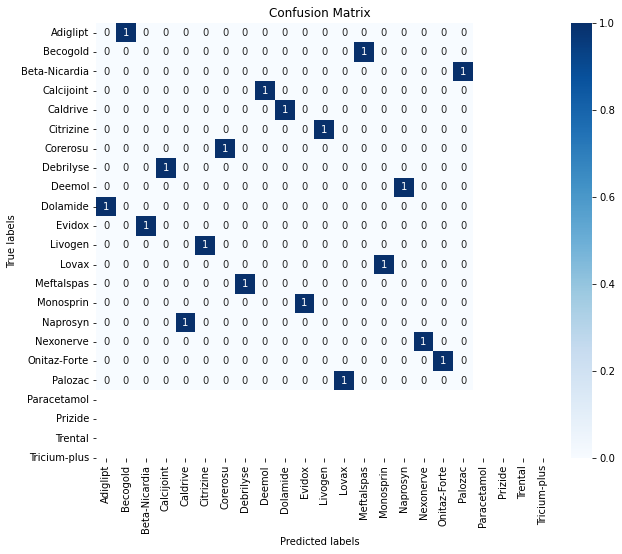

In [6]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions on the test data
y_pred = model.predict(test_datagen.flow(X_test))

# Convert one-hot encoded predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


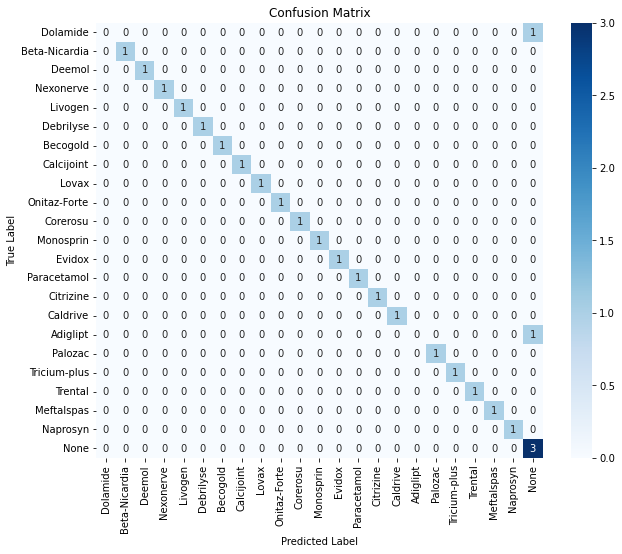

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Define the true and predicted labels
true_labels = [
    'Adiglipt', 'Becogold', 'Beta-Nicardia', 'Calcijoint', 'Caldrive', 
    'Citrizine', 'Corerosu', 'Debrilyse', 'Deemol', 'Dolamide', 
    'Evidox', 'None', 'None', 'None', 'Livogen', 'Lovax', 
    'Meftalspas', 'Monosprin', 'Naprosyn', 'Nexonerve', 
    'Onitaz-Forte', 'Palozac', 'Paracetamol', 'Trental', 'Tricium-plus'
]

predicted_labels = [
    'None', 'Becogold', 'Beta-Nicardia', 'Calcijoint', 'Caldrive', 
    'Citrizine', 'Corerosu', 'Debrilyse', 'Deemol', 'None', 
    'Evidox', 'None', 'None', 'None', 'Livogen', 'Lovax', 
    'Meftalspas', 'Monosprin', 'Naprosyn', 'Nexonerve', 
    'Onitaz-Forte', 'Palozac', 'Paracetamol', 'Trental', 'Tricium-plus'
]

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=list(set(true_labels)))

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(set(true_labels)), yticklabels=list(set(true_labels)))
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
